# Defining the model

In [1]:
# only for colab
# ! pip install --upgrade albumentations

In [1]:
import torch
import importlib
from tqdm.notebook import tqdm
import numpy as np

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [2]:
!nvidia-smi

Thu Jan  6 14:09:15 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 497.29       Driver Version: 497.29       CUDA Version: 11.5     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ... WDDM  | 00000000:0A:00.0  On |                  N/A |
|  0%   35C    P8    34W / 320W |   2501MiB / 10240MiB |      5%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

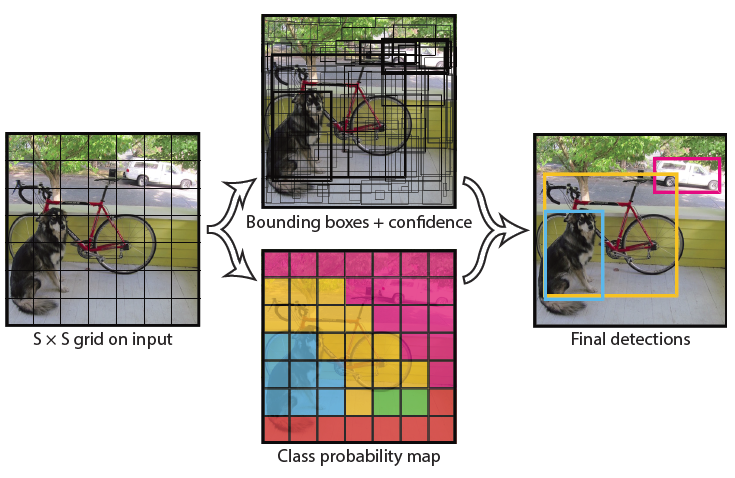

In [3]:
import dataset
import utils
import architecture
import wandb

from torch.optim import SGD
from torch.optim import Adam

In [4]:
wandb.login()

wandb: W&B API key is configured (use `wandb login --relogin` to force relogin)


True

## Architecture
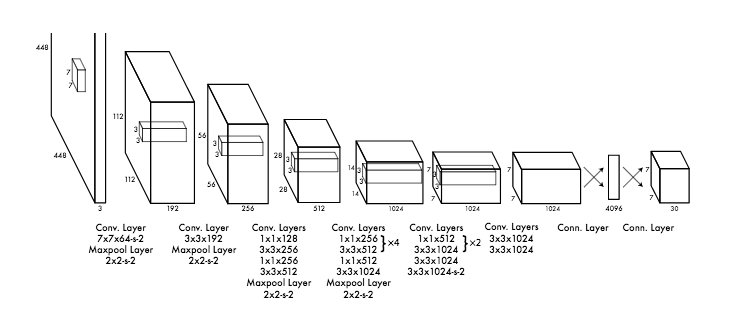

In [5]:
# net = architecture.darknet(batch_norm=True)
# print(net)

## Training

To avoid overfitting:
- dropout is used with rate 0.5 after the first connected layer
- extensive data augmentation is used - random scaling and translations of up to 20% of the original image size
- also randomly adjust the exposure and saturation of the image by up to factor of 1.5 in the HSV color space

### Constants

In [6]:
# from the paper
MOMENTUM = 0.9
EPOCHS = 150
DECAY = 0.0005
# model is trained with 135 epochs
# first 5 epochs from 0.001 to 0.1
# 75 epochs 0.01 epochs
# 30 epochs 0.001
# 30 epochs 0.0001
LEARNING_RATE = 0.00005
LAMBDA_NOOBJ = 0.5
LAMBDA_COORD = 5
SMOOTH = 1e-6

In [115]:
config = dict(
    # TRAINING PARAMS AND HYPERPARAMS
    epochs=EPOCHS,
    learning_rate=LEARNING_RATE,
    optimizer="Adam",
    momentum=MOMENTUM, # only needed for SGD
    # MODEL
    model_predefined=False,
    checkpoint=None, # only needed if model_predefined=True
    # DATASET PARAMS AND HYPERPARAMS
    batch_size=32,
    train_years=[2007, 2012],
    batch_norm=True,
    include_difficult=False,
    transforms=True,
    is_one_batch=False,
    # OTHER PARAMS TO SET
    fc_dropout=0.0, # set value of dropout in fully connected layer for overfitting, 0 means no dropout
    grid_size=7, # in paper this is S
    bounding_boxes=2, # in paper this is B
    classes=20 # in paper this is C
)

Using downloaded and verified file: ./data\VOCtrainval_06-Nov-2007.tar
Extracting ./data\VOCtrainval_06-Nov-2007.tar to ./data
Using downloaded and verified file: ./data\VOCtrainval_11-May-2012.tar
Extracting ./data\VOCtrainval_11-May-2012.tar to ./data
Using downloaded and verified file: ./data\VOCtest_06-Nov-2007.tar
Extracting ./data\VOCtest_06-Nov-2007.tar to ./data
Feature batch shape for training: torch.Size([32, 3, 448, 448])
Objects batch shape for training: 32
Labels matrix batch shape for training: torch.Size([32, 7, 7, 25])
Size of training set: 16576
Size of test set: 4960
Sample batch for training dataloader is presented below:


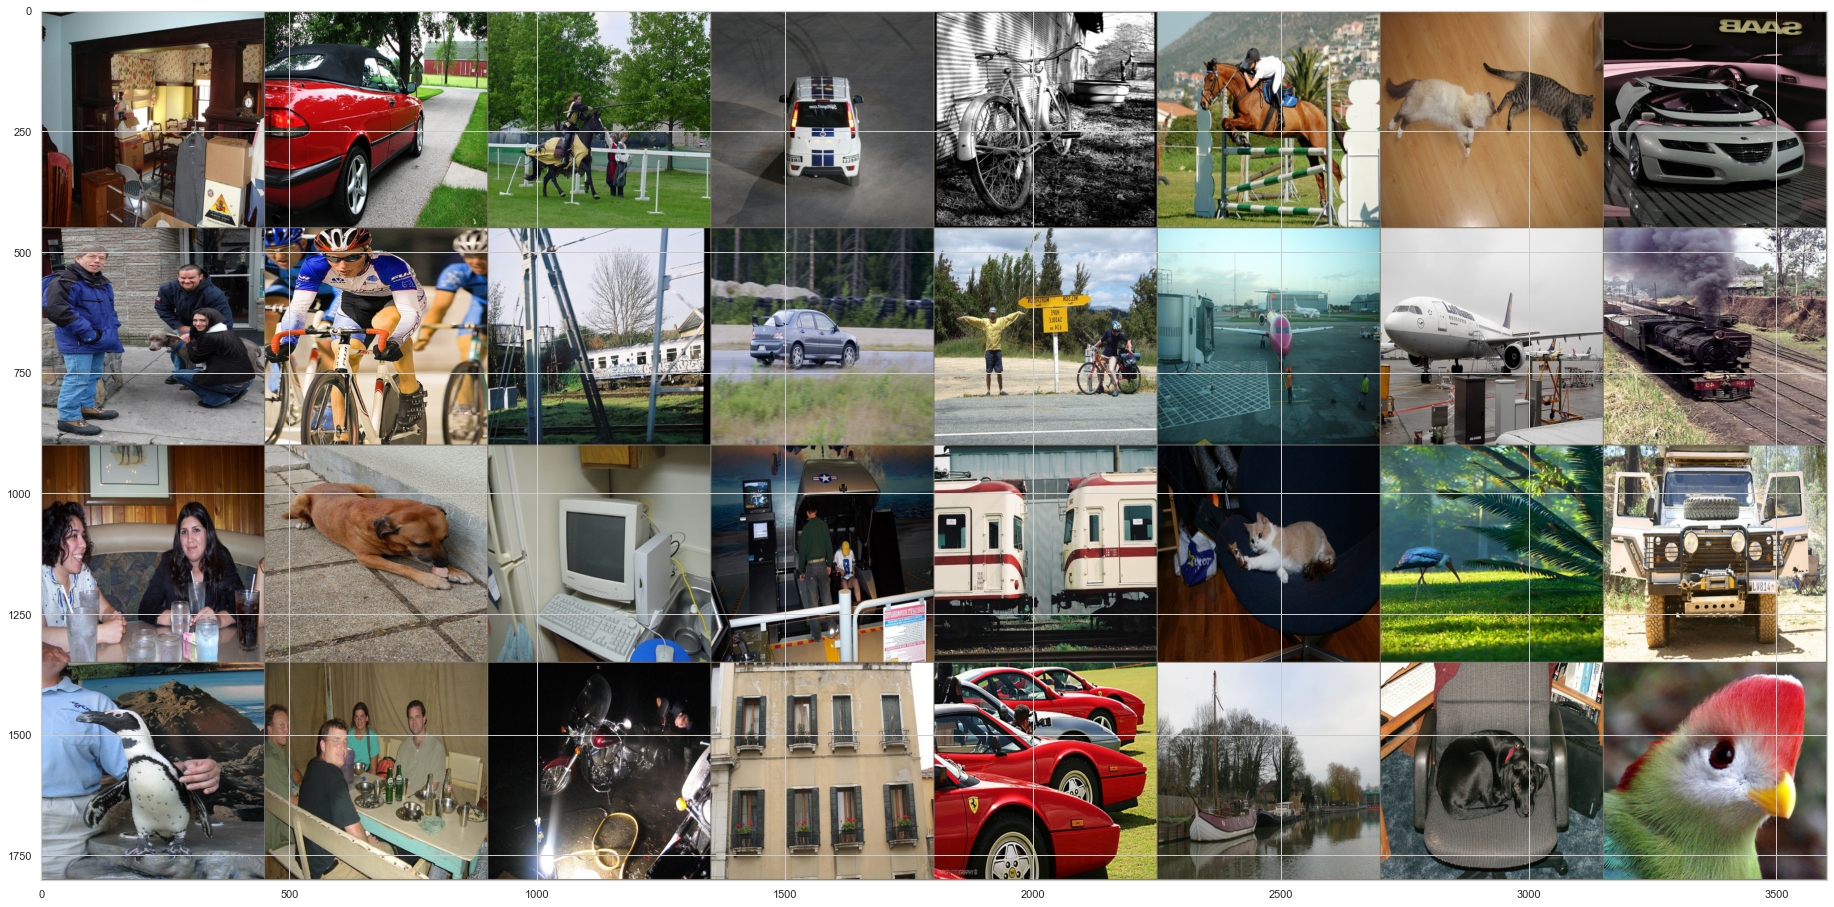

In [128]:
train_dl_predef, test_dl_predef = dataset.prepare_data(config["batch_size"], config["include_difficult"], config["transforms"], config["train_years"])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


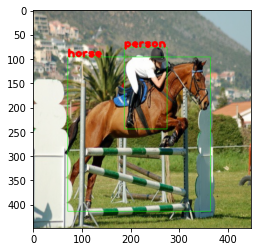

In [8]:
image, labels, _ = iter(train_dl_predef).next()
utils.show_image_with_classes_(image[5], labels[5])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


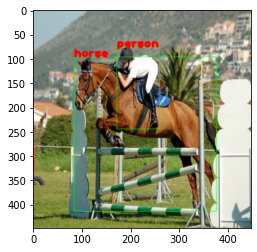

In [56]:
image, labels, _ = iter(train_dl_predef).next()
utils.show_image_with_classes_(image[5], labels[5])

In [62]:
labels[5]

array([[172.66666667,  76.30769231, 260.4       , 244.92307692,
          0.        ],
       [ 84.        ,  96.        , 376.13333333, 413.53846154,
          5.        ]])

In [84]:
img, lab = image[5], labels[5].copy()

In [85]:
un_norm = dataset.DeNormalize(dataset.MEAN, dataset.STD)
# denormalize the image
img = un_norm(img.clone()).numpy()
img = img.transpose((1, 2, 0)).copy()

In [86]:
lab[:, :4] = lab[:, :4] / 448

In [97]:
lab

array([[0.38541667, 0.17032967, 0.58125   , 0.5467033 , 0.        ],
       [0.1875    , 0.21428571, 0.83958333, 0.92307692, 5.        ]])

In [88]:
import albumentations as A

In [89]:
data_transform = A.Compose([
    A.Resize(448, 448), 
    # A.RandomCrop(224, 224),
    # A.HorizontalFlip(),
    # A.augmentations.transforms.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5, hue=0.25),
    A.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225],
    ), 
    A.pytorch.ToTensorV2()], 
    bbox_params=A.BboxParams(format='pascal_voc'))

In [94]:
data_transform = A.Compose(
            [A.Resize(448, 448, always_apply=True),
            A.Normalize(mean=dataset.MEAN, std=dataset.STD),
            A.pytorch.ToTensorV2()],
            bbox_params=A.BboxParams(format='pascal_voc')
        )

In [95]:
transformed = data_transform(image=img, bboxes=lab)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


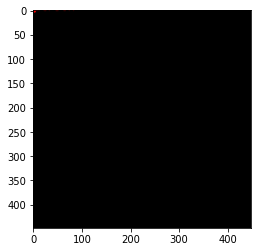

In [96]:
utils.show_image_with_classes_(transformed["image"], transformed["bboxes"])

In [ ]:
def visualize_augmentations(dataset, idx=0, samples=10, cols=5):
    dataset = copy.deepcopy(dataset)
    dataset.transform = A.Compose([t for t in dataset.transform if not isinstance(t, (A.Normalize, ToTensorV2))])
    rows = samples // cols
    figure, ax = plt.subplots(nrows=rows, ncols=cols, figsize=(12, 6))
    for i in range(samples):
        image, _ = dataset[idx]
        ax.ravel()[i].imshow(image)
        ax.ravel()[i].set_axis_off()
    plt.tight_layout()
    plt.show()

In [27]:
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [129]:
objects_dist = np.zeros(20)
images_dist = np.zeros(20)

In [130]:
for _, labels, _ in train_dl_predef:
    for object_array in labels:
        classes_array = np.zeros(20)
        for box in object_array:
            class_category = int(box[4])
            objects_dist[class_category] += 1
            
            if classes_array[class_category] != 1:
                classes_array[class_category] = 1
        images_dist += classes_array

In [131]:
objects_dist

array([13256.,  1605.,  1593.,   847.,  2025.,  1072.,  1070.,  1171.,
        1064.,  1140.,   822.,  3267.,  1052.,   925.,  1764.,  3152.,
         824.,  1487.,   814.,  1108.])

In [132]:
images_dist

array([6095., 1095., 1417.,  444., 1707.,  769.,  421.,  908.,  795.,
        689.,  607., 1874.,  771.,  805.,  950., 1564.,  738.,  772.,
        736.,  831.])

In [133]:
classes_dict = {'person': 0, 'bird': 1, 'cat': 2, 'cow': 3, 'dog': 4, 'horse': 5, 'sheep': 6, 'aeroplane': 7,
                'bicycle': 8, 'boat': 9, 'bus': 10, 'car': 11, 'motorbike': 12, 'train': 13, 'bottle': 14,
                'chair': 15, 'diningtable': 16, 'pottedplant': 17, 'sofa': 18, 'tvmonitor': 19}
inverse_classes_dict = {v: k for k, v in classes_dict.items()}

In [134]:
objects_dist_df = pd.DataFrame(np.concatenate((objects_dist.reshape(-1,1), images_dist.reshape(-1,1)), axis=1), columns=["Ilość obiektów", "Ilość zdjęć z obiektem"]).reset_index()
objects_dist_df = objects_dist_df.rename({'index': 'Klasa obiektu'}, axis='columns')
objects_dist_df = objects_dist_df.replace({"Klasa obiektu": inverse_classes_dict})
objects_dist_df

Klasa obiektu  Ilość obiektów  Ilość zdjęć z obiektem
0         person         13256.0                  6095.0
1           bird          1605.0                  1095.0
2            cat          1593.0                  1417.0
3            cow           847.0                   444.0
4            dog          2025.0                  1707.0
5          horse          1072.0                   769.0
6          sheep          1070.0                   421.0
7      aeroplane          1171.0                   908.0
8        bicycle          1064.0                   795.0
9           boat          1140.0                   689.0
10           bus           822.0                   607.0
11           car          3267.0                  1874.0
12     motorbike          1052.0                   771.0
13         train           925.0                   805.0
14        bottle          1764.0                   950.0
15         chair          3152.0                  1564.0
16   diningtable           824.0                   738.0
17   pottedplant          1487.0                   772.0
18          sofa           814.0                   736.0
19     tvmonitor          1108.0                   831.0

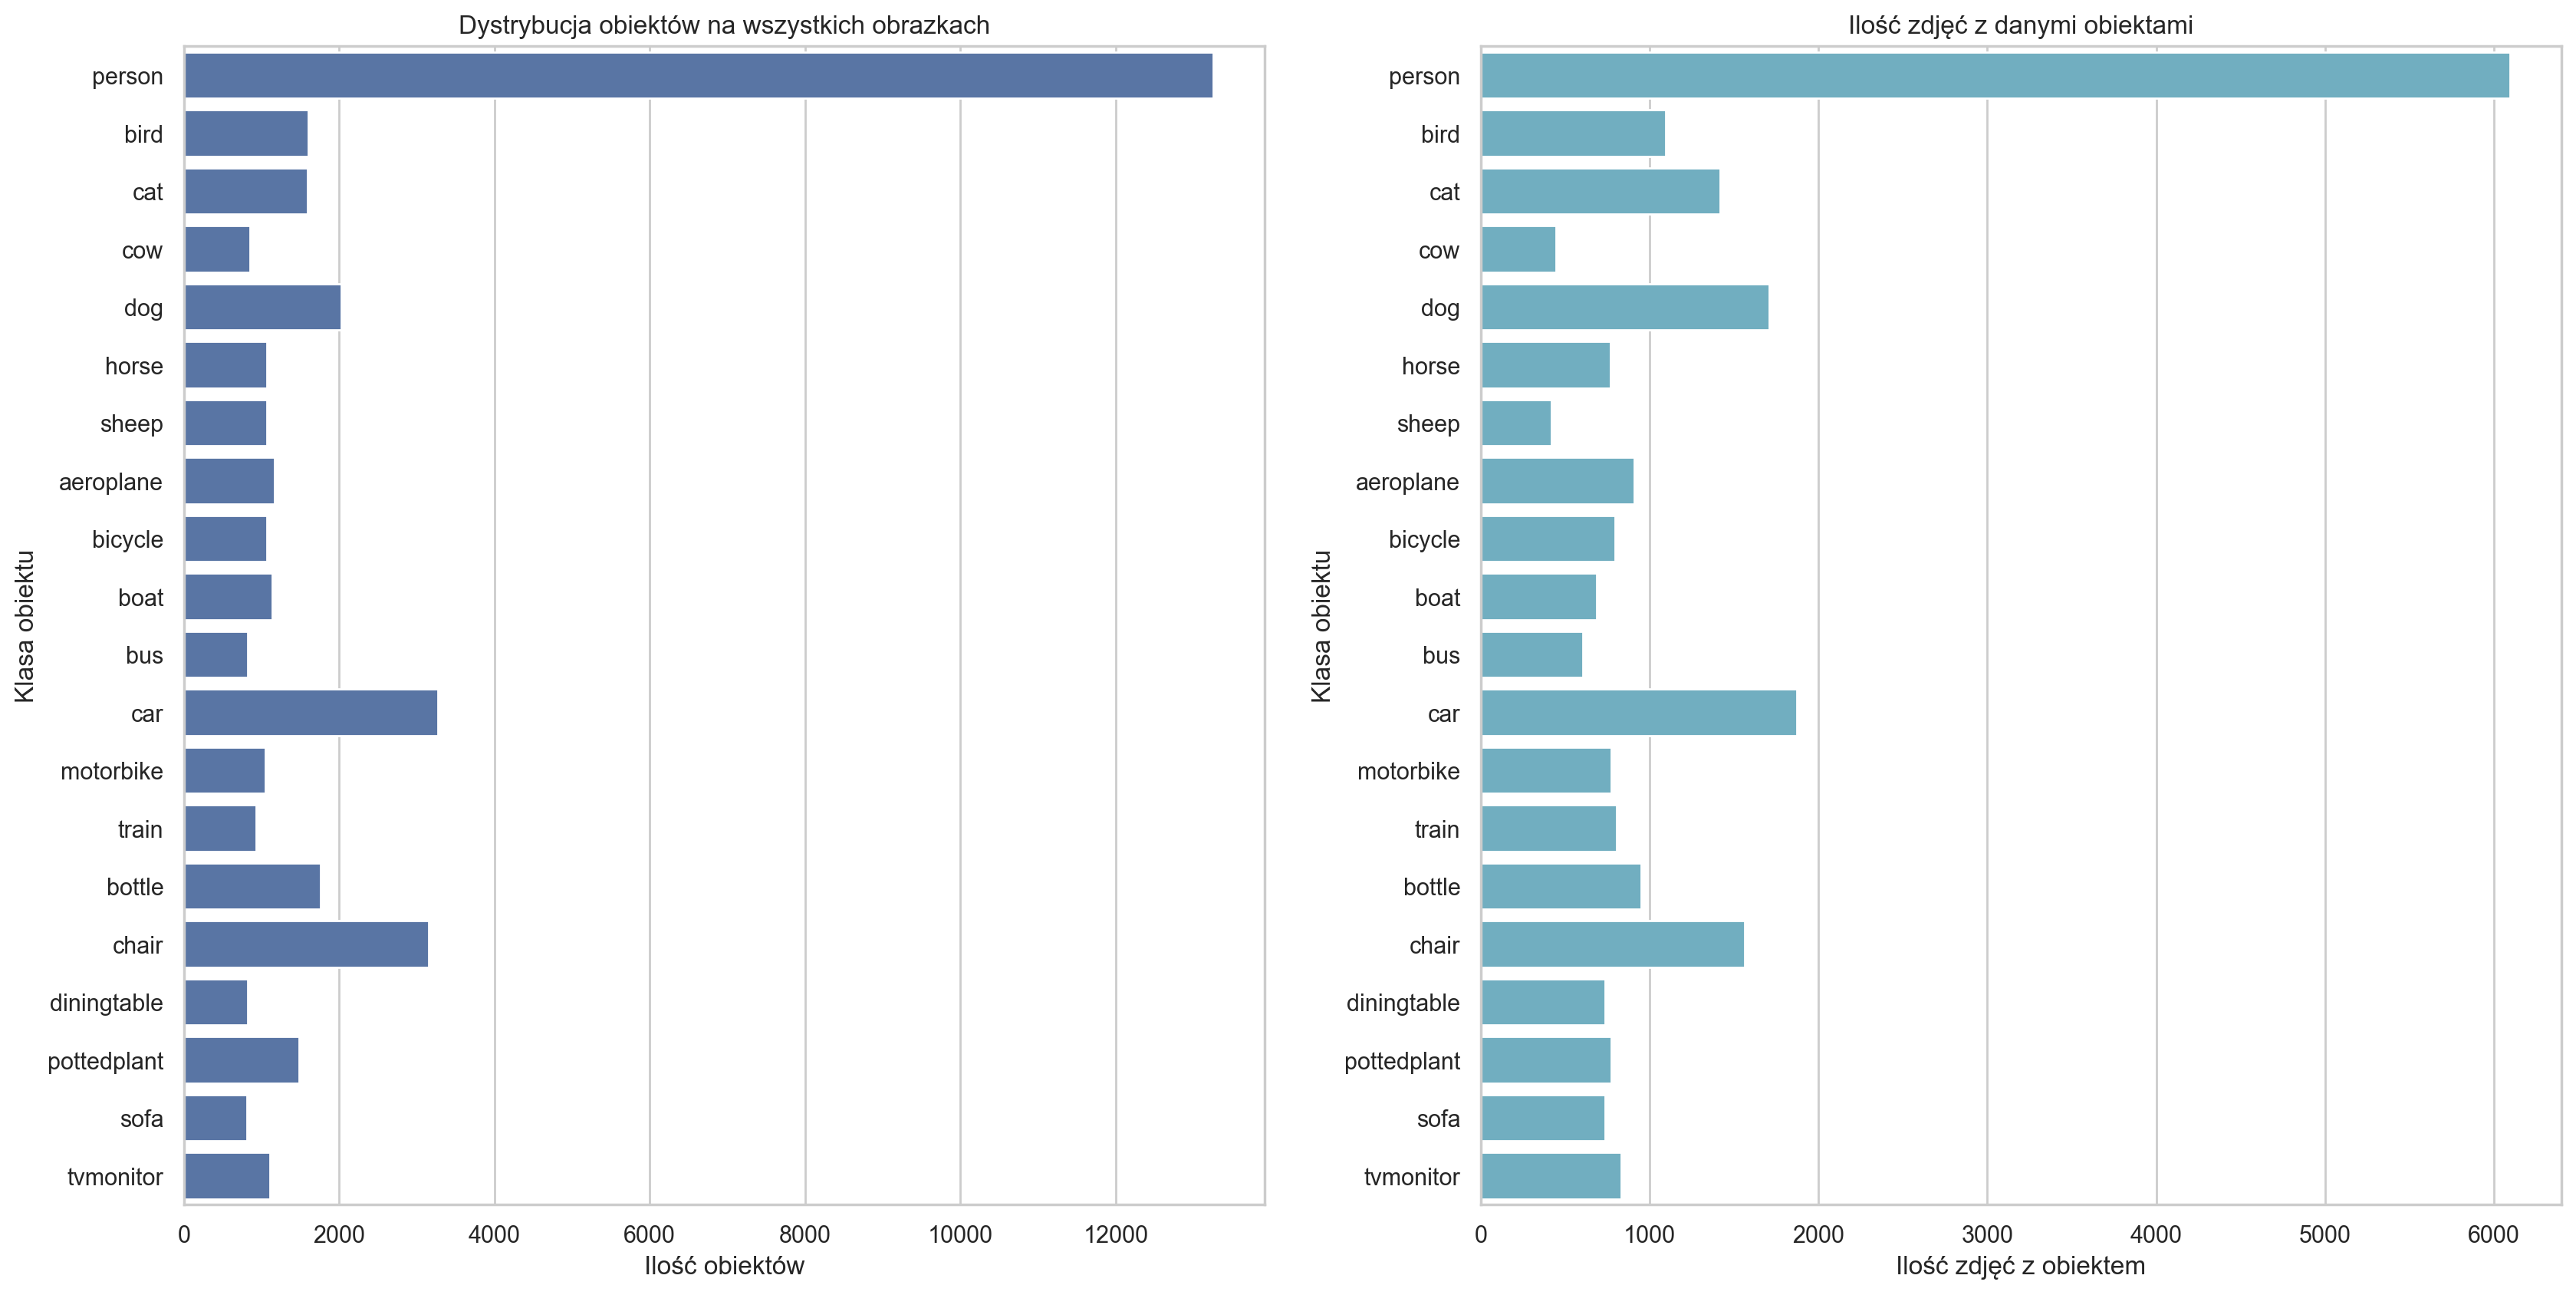

In [135]:
plt.figure(figsize=(20, 10), dpi=200)
# fig, ax = plt.subplots(nrows=1, ncols=2)

plt.subplot(1, 2, 1)
sns.barplot(x="Ilość obiektów", y="Klasa obiektu", color="b", data=objects_dist_df)
plt.title("Dystrybucja obiektów na wszystkich obrazkach")

plt.subplot(1, 2, 2)
sns.barplot(x="Ilość zdjęć z obiektem", y="Klasa obiektu", color="c", data=objects_dist_df)
plt.title("Ilość zdjęć z danymi obiektami")

plt.savefig("Dobra_dystrybucja.png")
plt.show()


In [84]:
from torchvision.datasets import VOCDetection

In [157]:
data = VOCDetection(
            root="./data",
            year="2007",
            image_set="trainval",
            transform=None,
            download=True
        )

Using downloaded and verified file: ./data\VOCtrainval_06-Nov-2007.tar
Extracting ./data\VOCtrainval_06-Nov-2007.tar to ./data


In [141]:
data2 = VOCDetection(
            root="./data",
            year="2012",
            image_set="trainval",
            transform=None,
            download=True
        )

Using downloaded and verified file: ./data\VOCtrainval_11-May-2012.tar
Extracting ./data\VOCtrainval_11-May-2012.tar to ./data


In [159]:
dist = {}

for i in range(len(data)):
    objects = data[i][1]["annotation"]["object"]
    for box in objects:
        if box["difficult"] != 1:
            name = box["name"]
            dist[name] = dist.get(name, 0) + 1
    

In [160]:
dist

{'chair': 1432,
 'car': 1644,
 'horse': 406,
 'person': 5447,
 'bicycle': 418,
 'cat': 389,
 'dog': 538,
 'train': 328,
 'aeroplane': 331,
 'diningtable': 310,
 'tvmonitor': 367,
 'bird': 599,
 'bottle': 634,
 'motorbike': 390,
 'pottedplant': 625,
 'boat': 398,
 'sofa': 425,
 'sheep': 353,
 'cow': 356,
 'bus': 272}

In [ ]:
dist = {}

In [146]:
for i in range(len(data2)):
    objects = data2[i][1]["annotation"]["object"]
    for box in objects:
        if box["difficult"] != 1:
            name = box["name"]
            dist[name] = dist.get(name, 0) + 1

In [147]:
for i in range(len(data)):
    objects = data[i][1]["annotation"]["object"]
    for box in objects:
        if box["difficult"] != 1:
            name = box["name"]
            dist[name] = dist.get(name, 0) + 1

In [148]:
dist

{'tvmonitor': 1193,
 'train': 984,
 'person': 15576,
 'boat': 1397,
 'horse': 1156,
 'cow': 1058,
 'bottle': 2116,
 'dog': 2079,
 'aeroplane': 1285,
 'car': 4008,
 'bus': 909,
 'bicycle': 1208,
 'chair': 4338,
 'diningtable': 1057,
 'pottedplant': 1724,
 'bird': 1820,
 'cat': 1616,
 'motorbike': 1141,
 'sheep': 1347,
 'sofa': 1211}

In [152]:
len(data) + len(data2)

16551

In [151]:
len(train_dl_predef)*32

16576